In [ ]:
!unzip /content/drive/MyDrive/EDI_Dataset_Zipped.zip

In [ ]:
# Importing all the required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from google.colab.patches import cv2_imshow
import cv2

import keras
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import load_img
from keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions

In [ ]:
np.random.seed(1234)

In [ ]:
train_datagen = ImageDataGenerator(zoom_range=0.5, shear_range=0.3,             # Generate batches of tensor image data
                                 horizontal_flip=True,
                                 preprocessing_function = preprocess_input)

val_datagen=ImageDataGenerator(preprocessing_function = preprocess_input )

In [ ]:
train = train_datagen.flow_from_directory(directory="/content/EDI_Dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train",
                                        target_size=(256,256),
                                        batch_size=(32))

val = val_datagen.flow_from_directory(directory="/content/EDI_Dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid",
                                        target_size=(256,256),
                                        batch_size=(32))

Found 24342 images belonging to 13 classes.
Found 6085 images belonging to 13 classes.


In [ ]:
# class_names = train.class_names
# print(class_names)

In [ ]:
t_img,label=train.next()
t_img.shape

(32, 256, 256, 3)

In [ ]:
def plot_image(img_arr,label):
  for im ,l in zip(img_arr,label):
    plt.figure(figsize=(5,5))
    plt.show()
    plt.imshow(im)

In [ ]:
# plot_image(t_img[:],label[:])

In [ ]:
def process_folder(folderpath):

    c = 0
    imagelist = os.listdir(folderpath)  # storing all the imagepaths in the list...
    for image in imagelist:
      if c != 2:
        imagepath = os.path.join(folderpath, image)

        img = cv2.imread(imagepath)

        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)  # Converting color image to gray image..
        ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)   # Applying Otsu's Thresholding Technique

        cv2_imshow(img)
        cv2_imshow(gray)
        cv2_imshow(thresh)

        c = c + 1
      else :
        break

In [ ]:
process_folder("/content/EDI_Dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Apple_scab")

# # Bulding Model

In [ ]:
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.applications.vgg19 import VGG19

In [ ]:
base_model = VGG19(input_shape=(256,256,3), include_top = False)

80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
for layer in base_model.layers:
  layer.trainable = False

In [ ]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
X = Flatten()(base_model.output)

X = Dense(units = 13, activation = 'softmax')(X)

# Creating the model
model = Model(base_model.input, X)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
model.compile(optimizer = 'adam', loss = keras.losses.categorical_crossentropy, metrics = ['accuracy'])

# Early Stopping and Model Check Point

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

#Early Stopping
es = EarlyStopping(monitor = "val_accuracy",
                   min_delta = 0.01,
                   patience = 3,
                   verbose = 1)

#Model Checkpoint
mc = ModelCheckpoint(filepath = "best_model.h5",
                     monitors = "val_accuracy",
                     min_delta = 0.01,
                     patience = 3,
                     verbose = 1,
                     save_best_only = True)

cb = [es, mc]

In [ ]:
his = model.fit_generator(train, steps_per_epoch = 16,
                          epochs = 50,
                          verbose = 1,
                          callbacks = cb,
                          validation_data = val,
                          validation_steps = 16)

<ipython-input-21-fdd1009aa6bc>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  his = model.fit_generator(train, steps_per_epoch = 16,


Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 12.9064 - accuracy: 0.4062
Epoch 1: val_loss improved from inf to 4.05599, saving model to best_model.h5
16/16 [==============================] - 28s 742ms/step - loss: 12.9064 - accuracy: 0.4062 - val_loss: 4.0560 - val_accuracy: 0.7441
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 4.5863 - accuracy: 0.7227
Epoch 2: val_loss improved from 4.05599 to 2.59801, saving model to best_model.h5
16/16 [==============================] - 12s 743ms/step - loss: 4.5863 - accuracy: 0.7227 - val_loss: 2.5980 - val_accuracy: 0.8516
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 3.1608 - accuracy: 0.8203
Epoch 3: val_loss improved from 2.59801 to 2.00767, saving model to best_model.h5
16/16 [==============================] - 15s 944ms/step - loss: 3.1608 - accuracy: 0.8203 - val_loss: 2.0077 - val_accuracy: 0.8809
Epoch 4/50
16/16 [==============================] - ETA: 0s - loss: 2.4049 - a

In [ ]:
h = his.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

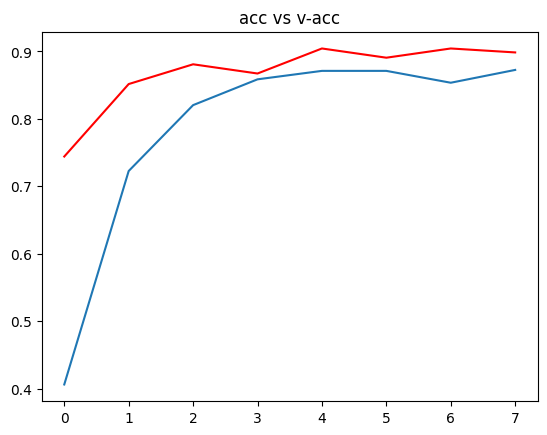

In [ ]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c = 'red')
plt.title('acc vs v-acc')
plt.show()

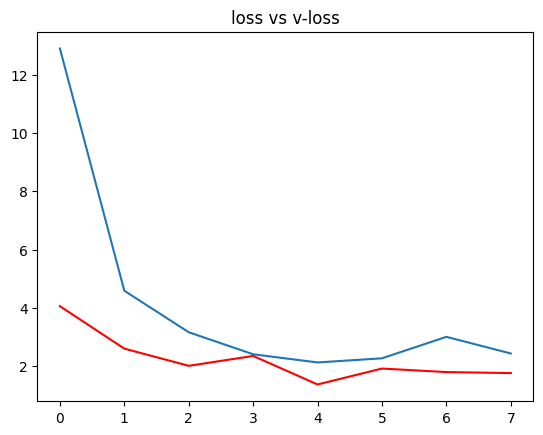

In [ ]:
plt.plot(h['loss'])
plt.plot(h['val_loss'], c = 'red')
plt.title('loss vs v-loss')
plt.show()

In [ ]:
# load best model

from keras.models import load_model

model = load_model("/content/best_model.h5")

In [ ]:
acc = model.evaluate(val)[1]

print(f"The Accuracy of the model is = {acc*100} %")

191/191 [==============================] - 41s 212ms/step - loss: 1.6104 - accuracy: 0.9047
The Accuracy of the model is = 90.46836495399475 %


In [ ]:
ref = dict(zip(list(train.class_indices.values()), list(train.class_indices.keys()) ))
ref

{0: 'Apple___Apple_scab',
 1: 'Apple___Cedar_apple_rust',
 2: 'Apple___healthy',
 3: 'Corn_(maize)___Common_rust_',
 4: 'Corn_(maize)___healthy',
 5: 'Grape___Black_rot',
 6: 'Grape___healthy',
 7: 'Potato___Early_blight',
 8: 'Potato___Late_blight',
 9: 'Potato___healthy',
 10: 'Tomato___Bacterial_spot',
 11: 'Tomato___Leaf_Mold',
 12: 'Tomato___healthy'}

In [ ]:
def predict(path):
  img = load_img(path, target_size=(256,256))

  i = img_to_array(img)

  im = preprocess_input(i)

  img = np.expand_dims(im, axis = 0)

  pred = np.argmax(model.predict(img))

  print(f"The image belongs to { ref[pred] } ")

In [ ]:
path = "/content/EDI_Dataset/test/test/CornCommonRust2.JPG"

predict(path)

1/1 [==============================] - 1s 609ms/step
The image belongs to Corn_(maize)___Common_rust_ 


In [ ]:
val_pred = model.predict(val).round(2)
val_pred

191/191 [==============================] - 41s 213ms/step


array([[0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
import pickle
pickle.dump(ref, open('classes.pkl', 'wb'))